How many standards did you use
10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in power


(10, 3.0, 'A = 0.05, est(A) = 1.07')
(10, 2.5, 'B = 1.00, est(B) = 2.41')
(10, 2.0, 'C = 0.05, est(C) = 0.07')
(10, 1.5, 'D = 1.06, est(D) = 0.09')


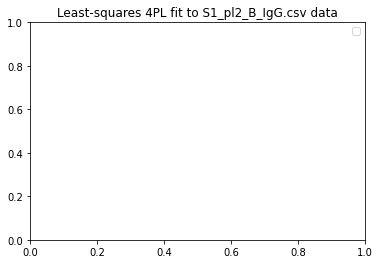

In [21]:
import pandas as pd
import glob,os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.interpolate import interp1d
workspace = "/home/fagi/Pulpit/ELISA/Worfolder/"
dir = os.chdir(workspace)
pd.set_option('display.max_rows', 1500)
pd.set_option('display.max_columns', 1500)
pd.set_option('display.width', 1500)
def import1d(x):
    df = pd.read_csv(x, sep = ';', index_col=0)
    out = np.empty(df.shape[0], dtype=object)
    out[:] = df.values.tolist()
    return out
def importdata(x):
    df = pd.read_csv(x, sep = ';', index_col=0)
    df = df.apply(lambda x: x.str.replace(',','.'))
    return df.astype("float")
def calcc(y):
    a = []
    const = (max(y)-min(y))/2
    for i in y :
        z = np.absolute(i-const)
        a.append(z)
    return min(a)
#Develop 4pl curve

def calcC(y):
    return np.median(y)

def logistic4(x, A, B, C, D):
    """4PL lgoistic equation."""
    return ((A-D)/(1.0+((C/x)**B)))+D # Logistic equation

def residuals(p, y, x): # Deviations of Data
    """Deviations of data from fitted 4PL curve"""
    A,B,C,D = p
    err = y-logistic4(x, A, B, C, D) 
    return err

def peval(x, p):
    """Evaluated value at x with current parameters."""
    A,B,C,D = p
    return logistic4(x, A, B, C, D)

def concentration(a,b,c,d,y):
    x = c*(((a-d)/(y-d))-1)**(1/b)
    return x 

def cuttable(x, wave):
    z = pd.read_csv(x, sep=";",header = None).fillna("")
    row = z[z[1].str.contains(wave)].index.values.astype(int)[0]
    name = z.iloc[row,1]
    table = z.iloc[row+2:row+10]
    table = pd.DataFrame(table).set_index([0])
    table = table.drop(columns=table.columns[(table == '').any()])
    table = table.apply(lambda x: x.str.replace(',','.'))
    return table.astype("float")

def r2value(y, y_predicted):
    ss_res = np.sum((y - y_predicted) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2
def rsqtable(x, y):
    pd.DataFrame(columns = ["x", "y", "y - yavg", "(y-yavg)^2", "ypred", "ypred - yavg", "(ypred-yavg)^2"])
    rsq["x"] = x
    rsq["y"] = y
    yavg = y.mean()
    rsq["y - yavg"] = rsq["y"] - yavg
    rsq["(y-yavg)^2"] = rsq["y - yavg"]**2
    rsq["ypred"] = y_true
    rsq["ypred - yavg"] = rsq["ypred"] - yavg
    rsq["(ypred-yavg)^2"] = rsq["ypred - yavg"]**2

def readsample(temp,df,S):
    z = []
    #Read Standards 
    for column in temp.columns: # search  in columns
        for row in temp.index: #search in rows
            y = temp.at[row,column] #find specific place
            if S in y: #
                z.append(row+":"+column) #fill list with locations of samples
    value = [] #create list for extracted values
    for i in z: 
        x = i[0] # take rows
        y = int(i[2]) # take column
        value.append(df.at[x,y]) #fill list with extracted values of samples
        avgvalue = np.mean(value) #count averages of repetitions
    return value, avgvalue
wells = pd.read_csv("../Plateorder.csv", sep = ";", index_col=0) #read wells 

template = pd.read_csv("ELISA B.csv", sep = ";", index_col=0) # Read sample sheet

csv = "S1_pl2_B_IgG.csv" #CSV from Reader
df450 = cuttable(csv, "450") #Cut 450 nm table
df570 = cuttable(csv, "570") #Cut 570 nm table
#Background substraction 
dfavg  = df450.sub(df570) #Cut background

temp = pd.read_csv("../Plateorder.csv")
#Read Standards 
standards = [] # Create standards
print("How many standards did you use")
countstandards = int(input()) #input number of standards
for i in range(1,countstandards+1):
    x = str(i)+"Standard"
    standards.append(x)# append list of S1..S2.. etc
np.unique(standards.append("B"))


col = []

for i in standards:   
    z,avg = readsample(template, dfavg, i)
    col.append(avg)
col = np.asarray(col)
#Attach Standards OD
y = col

x = np.array([1
,0.5
,0.25
,0.125
,0.0625
,0.03125
,0.015625
,0.0078125
,0.00390625
,0.001953125
,0
])

#Develop 4pl parameters

A = min(y)
D = max(y)
B = np.sign((y[-1]-y[0])/(x[-1]-x[0]))
C = calcc(y)

#A = -0.095
#D = 1.1555
#B = 0.88
#C = 0.11

y_true = np.flip(logistic4(x, A, B, C, D))
y_meas = y


# Initial guess for parameters
p0 = [1, 1, 1, 1]  

# Fit equation using least squares optimization
plsq = leastsq(residuals, p0, args=(y_meas, x))

#Plot results
#plt.plot(x,peval(x,plsq[0]),x,y_meas, "o",x,y_true)
plt.title(('Least-squares 4PL fit to %s data') % (csv))
plt.legend(['4pl Fit', 'Standards', 'Concentrations'], loc='best')
plt.savefig(('logistic%s.png') % (csv)) 

for i, (param, actual, est) in enumerate(zip('ABCD', [A,B,C,D], plsq[0])):
    print((10, 3-i*0.5, '%s = %.2f, est(%s) = %.2f' % (param, actual, param, est)))

In [22]:
x

array([1.        , 0.5       , 0.25      , 0.125     , 0.0625    ,
       0.03125   , 0.015625  , 0.0078125 , 0.00390625, 0.00195312,
       0.        ])

In [23]:
y

array([1.036 , 1.0475, 1.0575, 0.9145, 0.4545, 0.274 , 0.159 , 0.111 ,
       0.098 , 0.0465, 0.066 ])

In [24]:
print(r2value(y, y_true))

0.7460920308301726


In [25]:
print("R2 value" +" "+ str(r2value(y, y_true)))

R2 value 0.7460920308301726


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in power


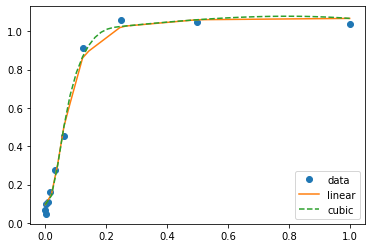

R2 value 0.9920202986046329


In [27]:
from scipy.optimize import curve_fit
popt, pcov = curve_fit(logistic4, x, y)
y_true = logistic4(x, *popt)


f = interp1d(x, y_true)
f2 = interp1d(x, y_true, kind='cubic')

xnew = np.linspace(min(x), max(x))
import matplotlib.pyplot as plt
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()
print("R2 value" +" "+ str(r2value(y, y_true)))

In [28]:
wells = pd.read_csv("../Plateorder.csv", sep = ";", index_col=0)
template = pd.read_csv("ELISA B.csv", sep = ";", index_col=0)
#Read Standards 
col = dfavg.iloc[:,0:2].astype("float")
col["mean"] = col.mean(axis=1)
col2 = dfavg.iloc[0:3,2:4].astype("float")
col2 = col2.mean(axis=1)
col = col["mean"].append(col2)
wells

,1,2,3,4,5,6,7,8,9,10,11,12
A,a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12
B,b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12
C,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12
D,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12
E,e1,e2,e3,e4,e5,e6,e7,e8,e9,e10,e11,e12
F,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12
G,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12
H,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12


In [8]:
dfavg

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
A,1.040,1.032,0.111,0.085,0.323,0.315,0.419,0.386,0.316,0.338,0.423,0.427
B,1.049,1.046,0.055,0.038,0.332,0.317,0.415,0.420,0.619,0.565,0.504,0.489
C,1.081,1.034,0.080,0.053,0.511,0.497,0.344,0.341,0.486,0.514,0.224,0.248
D,1.127,0.702,0.046,0.085,0.418,0.411,0.457,0.479,0.578,0.609,0.294,0.299
E,0.471,0.438,0.068,0.066,0.394,0.388,0.387,0.370,0.530,0.534,0.316,0.309
F,0.195,0.353,0.038,0.068,0.423,0.376,0.514,0.513,0.405,0.416,0.410,0.406
G,0.129,0.189,0.049,0.052,0.593,0.547,0.418,0.394,0.545,0.581,0.431,0.419
H,0.142,0.080,0.031,0.060,0.389,0.349,0.521,0.507,0.403,0.473,0.367,0.327


In [9]:
standards = []
for i in range(1,countstandards+1):
    x = str(i)+"Standard"
    print(i)
    standards.append(x)# append list of S1..S2.. etc
standards.append("B")
standards

1
2
3
4
5
6
7
8
9
10


['1Standard',
 '2Standard',
 '3Standard',
 '4Standard',
 '5Standard',
 '6Standard',
 '7Standard',
 '8Standard',
 '9Standard',
 '10Standard',
 'B']

In [13]:
col = []

for i in standards:   
    z,avg = readsample(template, dfavg, i)
    col.append(avg)
col = np.asarray(col)
#Attach Standards OD
y = col

In [14]:
y

array([1.036 , 1.0475, 1.0575, 0.9145, 0.4545, 0.274 , 0.159 , 0.111 ,
       0.098 , 0.0465, 0.066 ])